In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare data for convolution layers

In [2]:
# load weather channels

path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
weather_file = 'Data_collection_weather/feature_channel_28x20.npy'

feature_channel = np.load(path+weather_file, allow_pickle=False)
feature_channel.shape

(28, 20, 7, 204096)

In [3]:
# load installed capacity channels

path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
ic_file = 'Feature_engineering/installed_capacities_28x20.npy'

ic_channel = np.load(path+ic_file, allow_pickle=False)
ic_channel.shape

(28, 20, 2, 204096)

In [4]:
# stack all channels and rearange the axis to get the examples as the first 
# dimension for the use in tensorflow

feature_channel = np.dstack((feature_channel, ic_channel))

feature_channel = np.moveaxis(feature_channel, -1, 0)
feature_channel.shape

(204096, 28, 20, 9)

In [5]:
# get rid of all nans - replace them with -1
feature_channel = np.nan_to_num(feature_channel, nan=-0.0001)

<AxesSubplot:>

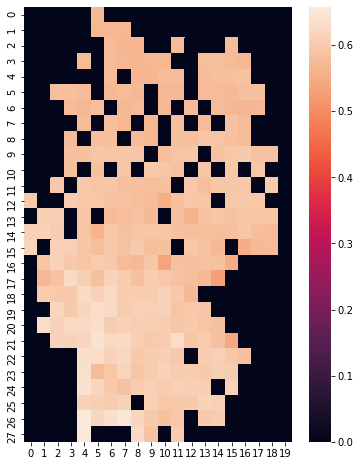

In [6]:
# make sure the change did work:
plt.figure(figsize = (6,8))
sns.heatmap(feature_channel[80_045,::-1,:,0])

In [7]:
# load the target values
path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
file_load = 'Data_collection_entsoe/Day_ahead_dataset.csv'
df_load = pd.read_csv(path+file_load)

df_load.shape

(204096, 10)

In [8]:
# keep only the target values
df_load.drop(columns=['index', 'Day ahead/System total load in MAW',
       'Day ahead/Solar in MAW',
       'Day ahead/Wind Onshore in MAW', 'Day ahead/Wind Offshore in MAW'], inplace=True)

print(df_load.shape)
df_load.head()

(204096, 5)


,Date,Realised/Solar in MAW,Realised/Wind Onshore in MAW,Realised/System total load in MAW,Realised/Wind Offshore in MAW
0,2014-12-31 23:00:00,0.0,8113.0,42976.0,520.0
1,2014-12-31 23:15:00,0.0,8092.0,42540.0,517.0
2,2014-12-31 23:30:00,0.0,8161.0,42638.0,514.0
3,2014-12-31 23:45:00,0.0,8146.0,42483.0,515.0
4,2015-01-01 00:00:00,0.0,8183.0,41917.0,515.0


In [9]:
df_load = df_load.interpolate()

In [10]:
df_load.isnull().sum().sum()

0

In [11]:
def min_max_normalize_target_var(df):
    # fix the min and max according to phisical properties:
    X_max = 100_000
    
    for col in df.columns:
        df[col] /= X_max
        
    return df

In [12]:
df_load_norm = min_max_normalize_target_var(df_load.iloc[:,1:]) # avoid Date

In [13]:
df_load_norm.head()

,Realised/Solar in MAW,Realised/Wind Onshore in MAW,Realised/System total load in MAW,Realised/Wind Offshore in MAW
0,0.0,0.08113,0.42976,0.00520
1,0.0,0.08092,0.42540,0.00517
2,0.0,0.08161,0.42638,0.00514
3,0.0,0.08146,0.42483,0.00515
4,0.0,0.08183,0.41917,0.00515


In [14]:
np_load = df_load_norm.to_numpy(copy=True)

In [15]:
# check shape of target variable
np_load.shape

(204096, 4)

In [16]:
# Define X_train, X_val, Y_train, Y_val
def train_val_test_split(feature_matrix, target_matrix, val_days, test_days):
    '''
    Split a time series data set into train, validation and test set
    INPUT:
    - feature_matrix: dataset in numpy array form with the set of features for training
    - target_matrix: dataset in numpy array form with the set of target variables
    - val_days: integer representing number of days to use for the validation set
    - test_days: integer representing number of days to use for the test set

    OUTPUT:
    - X_train: data set for training
    - y_train: matrix with target variables for training
    - X_val: data set for validation
    - y_val: matrix with target variables for validation
    - X_test: data set to test the model
    - y_val: matrix with target variables for testing
    '''

    print('The shape of the feature data set is: {}'.format(feature_matrix.shape))
    print('The shape of the target data set is: {}'.format(target_matrix.shape))

    rows_for_test = test_days*96
    rows_for_val = val_days*96

    #target_vars_for_test = target_vars.copy()
    #target_vars_for_test.append('Date')

    #df_features = df.drop(columns=target_vars_for_test).copy()
    #df_target = df[target_vars].copy()
    #df_target_test = df[target_vars_for_test].copy()

    X_train = feature_matrix[105_120:-(rows_for_test + rows_for_val)]
    y_train = target_matrix[105_120:-(rows_for_test + rows_for_val)]
    print('\n--------------------------------------------')
    print('The shape of the train set is: {}'.format(X_train.shape))
    print('The shape of the target variable is: {}'.format(y_train.shape))
    print('--------------------------------------------')

    X_val = feature_matrix[X_train.shape[0]+105_120:-(rows_for_test)]
    y_val = target_matrix[y_train.shape[0]+105_120:-(rows_for_test)]
    print('\n--------------------------------------------')
    print('The shape of the validation set is: {}'.format(X_val.shape))
    print('The shape of the target variable for the validation set is: {}'.format(y_val.shape))
    print('--------------------------------------------')

    X_test = feature_matrix[X_val.shape[0]+X_train.shape[0]+105_120:]
    y_test = target_matrix[y_val.shape[0]+X_train.shape[0]+105_120:]
    print('\n--------------------------------------------')
    print('The shape of the test set is: {}'.format(X_test.shape))
    print('The shape of the target variable for the test set is: {}'.format(y_test.shape))
    print('--------------------------------------------')

    return X_train, y_train, X_val, y_val, X_test, y_test

In [17]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(feature_channel, np_load, 90, 90)

The shape of the feature data set is: (204096, 28, 20, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 28, 20, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 28, 20, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 28, 20, 9)
The shape of the target variable for the test set is: (8640, 4)
--------------------------------------------


# Set up the CNN

In [18]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3),
          activation='relu',
          padding='same',
          input_shape=(28, 20, 9))
         )
model.add(layers.Conv2D(32, (3, 3),
          activation='relu',
          padding='same')
         )
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3),
          activation='relu',
          padding='same')
         )
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(128, (3, 3),
          activation='relu',
          padding='same')
         )
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 20, 32)        2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 20, 32)        9248      
_________________________________________________________________
dropout (Dropout)            (None, 28, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 20, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 20, 128)       73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 20, 128)       0

In [19]:
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mean_absolute_error'])

In [20]:
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs = 10,
                    validation_data=(X_val,y_val),
                    shuffle=False)

Epoch 1/10
1277/1277 [==============================] - 306s 239ms/step - loss: 0.0346 - mean_absolute_error: 0.0688 - val_loss: 0.0044 - val_mean_absolute_error: 0.0532
Epoch 2/10
1277/1277 [==============================] - 305s 239ms/step - loss: 0.0037 - mean_absolute_error: 0.0430 - val_loss: 0.0029 - val_mean_absolute_error: 0.0416
Epoch 3/10
1277/1277 [==============================] - 307s 240ms/step - loss: 0.0032 - mean_absolute_error: 0.0395 - val_loss: 0.0027 - val_mean_absolute_error: 0.0398
Epoch 4/10
1277/1277 [==============================] - 304s 238ms/step - loss: 0.0030 - mean_absolute_error: 0.0379 - val_loss: 0.0027 - val_mean_absolute_error: 0.0386
Epoch 5/10
1277/1277 [==============================] - 300s 235ms/step - loss: 0.0028 - mean_absolute_error: 0.0368 - val_loss: 0.0025 - val_mean_absolute_error: 0.0373
Epoch 6/10
1277/1277 [==============================] - 301s 236ms/step - loss: 0.0027 - mean_absolute_error: 0.0360 - val_loss: 0.0024 - val_mean_abs

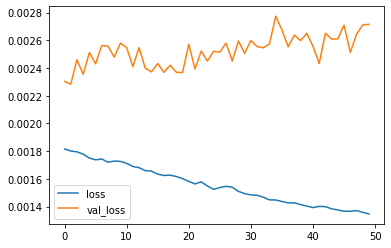

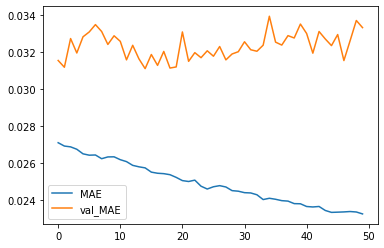

In [27]:
history.history
plt.plot(history.history["loss"],label = "loss")
plt.plot(history.history["val_loss"],label = "val_loss")
plt.legend()
plt.show()
plt.close()


history.history
plt.plot(history.history["mean_absolute_error"],label = "MAE")
plt.plot(history.history["val_mean_absolute_error"],label = "val_MAE")
plt.legend()
plt.show()
plt.close()

In [21]:
y_pred = model.predict(X_test)

In [22]:
y_pred.shape

(8640, 4)

In [30]:
  raise Exception("Stop the kernel!") 

Exception: Stop the kernel!

In [23]:
from sklearn.metrics import mean_absolute_error

def get_model_metrics(y_true_with_date, y_prediction):

    y_true = np.array(y_true_with_date.iloc[:,1])
    y_pred = np.array(y_prediction)


    # get the total error and the overall MAE

    overall_mae = mean_absolute_error(y_true, y_pred)
    absolute_error = overall_mae * len(y_true)

    print('\n----------------------------------------------')
    print(f'The absolute error (total actual minus  forecast) in MW is: {round(absolute_error, 2)}')
    print('----------------------------------------------\n')

    print('\n----------------------------------------------')
    print(f'The overall mean absolute error of the model in MW is: {overall_mae}')
    print('----------------------------------------------\n')

    # get the overall mean absolute scaled error (MASE)

    naive_forecast = y_true[1:]
    y_true_for_mase = y_true[:-1]
    mae_naive = mean_absolute_error(y_true_for_mase, naive_forecast)
    overall_mae_without_first_observation = mean_absolute_error(y_true[1:], y_pred[1:])

    overall_mase = overall_mae_without_first_observation/mae_naive

    print('\n----------------------------------------------')
    print(f'The overall mean absolute scaled error of the model in MW is: {overall_mase}')
    print('Please note: to calculate the MASE, the prediction for the first observation was omitted')
    print('----------------------------------------------\n')

    # get the MAE for every day and return a dataframe and charts

    time_stamp = np.array(
                 pd.to_datetime(y_true_with_date.iloc[:,0], format='%Y-%m-%d %H:%M:%S').dt.date
                 )

    date_list = list()
    y_true_list = list()
    y_pred_list = list()

    df = pd.DataFrame({'Date': time_stamp,
                       'y_true': y_true,
                       'y_pred': y_pred})

    list_of_days = sorted(list(set(df.Date.values)))

    for day in list_of_days:
        sub_df = df.query('Date == @day')
        date_list.append(sub_df.Date.values)
        y_true_list.append(sub_df.y_true.values)
        y_pred_list.append(sub_df.y_pred.values)

    mae_list = list()
    for i, j, k in zip(y_true_list, y_pred_list, date_list):
        MAE = mean_absolute_error(i, j)
        mae_list.append(MAE)

    del df

    df = pd.DataFrame({'day':list_of_days, 'MAE': mae_list},)

    print('\n----------------------------------------------')
    print('This function also returns a dataframe with the MAE for each day')
    print('----------------------------------------------\n')

    return df

In [24]:
print(y_test[:,3])
print(y_pred[:,3])

[0.05294 0.05353 0.05336 ... 0.04525 0.04525 0.04525]
[0.02642127 0.02620994 0.0259494  ... 0.03073267 0.03073267 0.03073267]


In [25]:
# re-scaled the results
y_test *= 100_000
y_pred *= 100_000

print(y_test[:,3])
print(y_pred[:,3])

[5294. 5353. 5336. ... 4525. 4525. 4525.]
[2642.1272 2620.9944 2594.9397 ... 3073.267  3073.267  3073.267 ]


In [26]:
# create dataframe for y_test with dates

y_true_with_date = pd.DataFrame({'Date':df_load.iloc[-y_test.shape[0]:,0],
                                 'solar':y_test[:,0], 
                                 'wind_onshore':y_test[:,1], 
                                 'load':y_test[:,2], 
                                 'wind_offshore':y_test[:,3]})

In [28]:
list_names = ["solar","wind_onshore", "load", "wind_offshore"]

metrics_dict = dict()
for i in range(len(y_pred[0])):
    print("\n=================================")
    print(f"{list_names[i]}")
    metrics_dict[list_names[i]] = get_model_metrics(y_true_with_date.iloc[:,[0,i+1]],y_pred[:,i])
    print("=================================\n")


solar

----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 29816814.44
----------------------------------------------


----------------------------------------------
The overall mean absolute error of the model in MW is: 3451.0201902460167
----------------------------------------------


----------------------------------------------
The overall mean absolute scaled error of the model in MW is: 8.571790025466921
Please note: to calculate the MASE, the prediction for the first observation was omitted
----------------------------------------------


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------



wind_onshore

----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 26672897.48
----------------------------------------------


---------------------------------------------